In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-11-18 20:02:15.709532: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 20:02:16.200984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 20:02:17.413748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mydevices = tf.config.get_visible_devices()
tf.config.set_visible_devices(mydevices[0:1]+mydevices[1:2])
mydevices = tf.config.get_visible_devices()
print(mydevices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def compute_output_shape(self, input_shape):
        return input_shape
        
    def call(self, x, training):
        y = x
        y = self.layernorm1(y, training=training)
        y, scores = self.att(y, y, return_attention_scores=True, training=training)
        y = self.dropout1(y, training=training)
        x += y
        y = x
        y = self.layernorm2(y, training=training)
        y = self.ffn(y, training=training)
        y = self.dropout2(y, training=training)
        return (x + y, scores)


In [4]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2] # x already embedded
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [5]:
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

## Standardize the -input- data between 0.0-1.0 (real)
## instead of the default 0-255 (integer)
x_train = np.expand_dims(x_train,-1)
x_val = np.expand_dims(x_val,-1)

x_train = x_train / 255.0
x_val = x_val / 255.0

# Convert class vector [0-9] to categorical assignments (one-hot)
# y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
# y_test = keras.utils.to_categorical(y_test, len(np.unique(y_test)))

display(x_train.shape)
display(y_train.shape)
display(x_val.shape)
display(y_val.shape)

(60000, 28, 28, 1)

(60000,)

(10000, 28, 28, 1)

(10000,)

In [ ]:
embed_dim = 128
kernel = 4
num_heads = 6
ff_dim = 512
stack = 5

# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
y = x = keras.layers.Input(shape=x_train.shape[1:])
# This layer will just be passed a constant integer for
# embedding (class token - see the ViT paper)
# input_class = keras.layers.Input(shape=(1,))

# Patches
y = keras.layers.Conv2D(embed_dim,
                        kernel_size=(kernel,kernel),
                        strides=(kernel,kernel))(y)
# Hybrid CNN
# y = keras.layers.Conv2D(embed_dim*2,
#                         kernel_size=(5, 5),
#                         strides=2,
#                         activation='gelu')(y)
# y = keras.layers.Conv2D(embed_dim,
#                         kernel_size=(5, 5),
#                         strides=2,
#                         activation='gelu')(y)

# Flatten 2D arrangement to 1D arrangement of tokens
y = keras.layers.Reshape((-1,embed_dim))(y)
y = PositionEmbedding(y.shape[-2],embed_dim)(y)

# Create class token
c = keras.layers.Lambda(lambda x: tf.tile(tf.constant([[0]]),(tf.shape(x)[0],1)))(y)
c = keras.layers.Embedding(input_dim=1,output_dim=embed_dim)(c)

# Prepend class token
y = keras.layers.Concatenate(axis=1)([c,y])

for _ in range(stack):
    y = TransformerBlock(embed_dim, num_heads, ff_dim)(y)[0]
# Lambda layer is like the ViT the paper...
# y = keras.layers.Lambda(lambda x: x[:,0,:])(y)
# Use the following -instead- of Lambda is common in other
# models I have seen... probably not important though
y = keras.layers.GlobalAveragePooling1D()(y)
y = keras.layers.Dropout(0.1)(y)
y = keras.layers.Dense(embed_dim,activation='gelu')(y)
#    y = keras.layers.Dropout(0.5)(y)
y = keras.layers.Dense(10)(y)

model = keras.Model(x,y)
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=keras.metrics.SparseCategoricalAccuracy())
model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [8]:
batch_size = 512
epochs = 20
#with strategy.scope():
history = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_data = (x_val, y_val))

Epoch 1/20


2023-04-12 13:36:53.857932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-12 13:36:54.768657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-12 13:36:55.014544: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe7cb171360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-12 13:36:55.014588: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-12 13:36:55.019894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-12 13:36:55.116261: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

118/118 [==============================] - 29s 98ms/step - loss: 1.1225 - sparse_categorical_accuracy: 0.6120 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.7843
Epoch 2/20
118/118 [==============================] - 11s 95ms/step - loss: 0.4454 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.3546 - val_sparse_categorical_accuracy: 0.8832
Epoch 3/20
118/118 [==============================] - 11s 95ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.3796 - val_sparse_categorical_accuracy: 0.8797
Epoch 4/20
118/118 [==============================] - 11s 95ms/step - loss: 0.2427 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.2433 - val_sparse_categorical_accuracy: 0.9202
Epoch 5/20
118/118 [==============================] - 11s 95ms/step - loss: 0.1944 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.3324 - val_sparse_categorical_accuracy: 0.8939
Epoch 6/20
118/118 [==============================] - 11s 95ms/step - loss: 0.1614 - sparse_categoric

In [9]:
# Final Result - Generalization!
score = model.evaluate(x_val, y_val, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9810
Validation loss: 0.06410568207502365
Validation accuracy: 0.9810000061988831


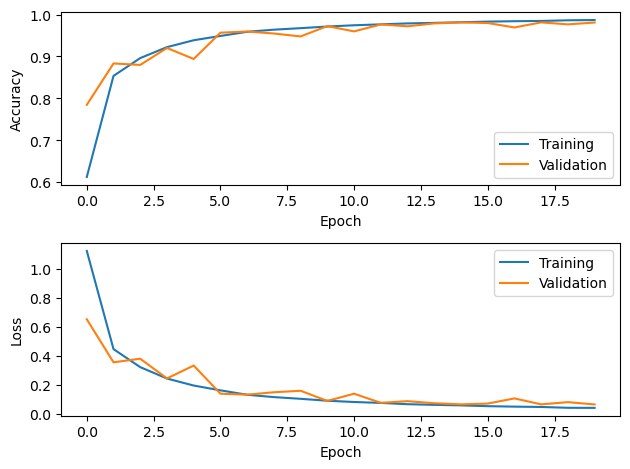

In [10]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['sparse_categorical_accuracy'])  
plt.plot(history.history['val_sparse_categorical_accuracy'])  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Training', 'Validation'], loc='lower right')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Training', 'Validation'], loc='upper right') 

plt.tight_layout()
plt.show()  

# Exploration

In [11]:
from tensorflow.keras import backend as K

In [12]:
ins = model.input
outs = [layer.output[1] for layer in model.layers if type(layer) == TransformerBlock]
functor = K.function(ins, outs)

In [113]:
i = 0

In [114]:
data = functor(x_train[i:i+1])

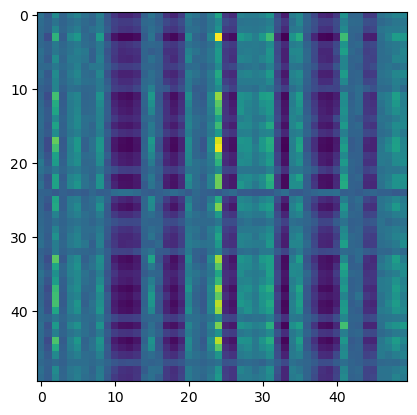

In [115]:
plt.imshow(data[0][0][0])
plt.show()

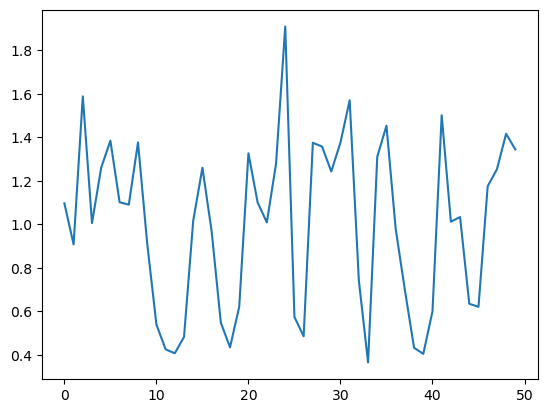

In [116]:
plt.plot(np.sum(data[0][0][0],0))
plt.show()

In [117]:
att_mask = keras.preprocessing.image.smart_resize(np.reshape(tf.nn.softmax(np.max([np.max(x[0],(0,1)) for x in data],0)[1:]).numpy(),(7,7,1)),(28,28),interpolation='area')

In [118]:
np.sum(att_mask)

16.0

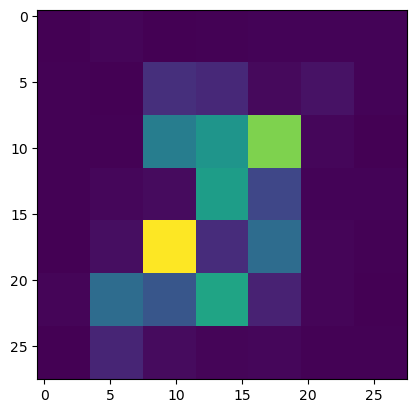

In [119]:
plt.imshow(att_mask)
plt.show()

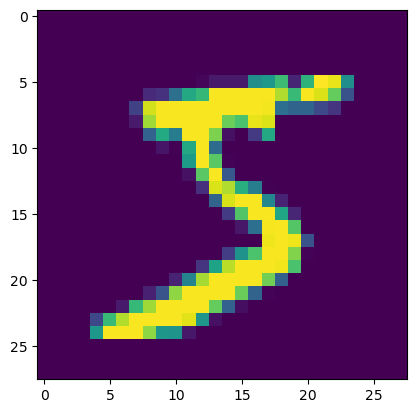

In [120]:
plt.imshow(x_train[i])
plt.show()

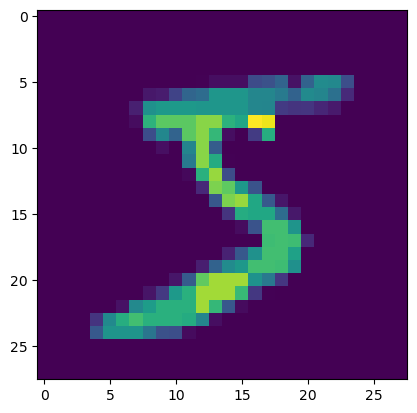

In [122]:
plt.imshow(x_train[i]*att_mask)
plt.show()